# Figure 1: Study area and forcing fields applied in model experiments

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import cftime
import matplotlib.path as mpath
import sys
sys.path.append(
    "/g/data/e14/cs6673/Ross_salinity/Python_scripts_published/") 
from Info_definitions import (
    path_database, path_output, path_plots, exptdict)
import pandas as pd

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cmocean
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
from wrf import to_np # conversion to arrays required for arrows on maps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36411/status,
Dashboard: /proxy/36411/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32851,Workers: 7
Dashboard: /proxy/36411/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:33257,Total threads: 4
Dashboard: /proxy/40171/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:42399,


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23307735971648 and this is thread id 23306135205632.
Exception closing connection <sqlite3.Connection object at 0x153260eb3840>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/sit

## Load data

### Wind forcing

In [4]:
def yearly_mean_Nov_Feb(data):
    # Compute the number of days in each month
    days_in_month = data['time'].dt.days_in_month
    
    # Select only the months Nov-Feb
    # Adjust year grouping for Nov-Feb to treat it as a single season
    nov_feb = data.sel(time=data['time'].dt.month.isin([11, 12, 1, 2]))
    
    # Assign season-year for Nov-Feb (shift the year for Jan-Feb back to Nov-Dec's year)
    season_year = nov_feb['time.year'].where(nov_feb['time.month'] > 2, nov_feb['time.year'] - 1)
    
    # Add the season-year coordinate for grouping
    nov_feb = nov_feb.assign_coords(season_year=season_year)
    
    # Calculate weighted values
    weights = days_in_month.sel(time=nov_feb['time'])
    weighted_data = nov_feb * weights
    
    # Aggregate weighted values over the Nov-Feb period for each season_year
    weighted_mean = (weighted_data.groupby('season_year').sum(dim='time') /
                     weights.groupby('season_year').sum(dim='time'))
    weighted_mean = weighted_mean.rename({'season_year': 'time'})
    weighted_mean.attrs = {'time average': 'seasonal (NOV-FEB) weighted mean'}
    
    # Resulting time series
    return weighted_mean

In [5]:
def mask_from_polygon(lon, lat, xt_ocean, yt_ocean):
    polygon = [(lon[0], lat[0])]
    for l in range(1, len(lon)):
        polygon += [(lon[l], lat[l])]
    poly_path = mpath.Path(polygon)

    x, y = xr.broadcast(xt_ocean, yt_ocean)
    coors = np.hstack((x.values.reshape(-1, 1), y.values.reshape(-1, 1)))

    mask = poly_path.contains_points(coors)
    mask = mask.reshape(xt_ocean.size, yt_ocean.size).transpose()
    mask = xr.DataArray(
        mask, dims = ['lat', 'lon'],
        coords={'lon': xt_ocean, 'lat': yt_ocean})
    return mask

In [6]:
%%time
ekeys = ['ctrl', 'wind_50_down_zonal', 'era5']

# masks for land, shelf and area of wind perturbation
ht = cc.querying.getvar(
    '01deg_jra55v13_ryf9091_rerun_for_easterlies', 'ht',
    session=cc.database.create_session(), n=1).sel(
    yt_ocean=slice(-90, -60))
land_mask = (ht*0).fillna(1)
mask_wind = [
    [360-167, 360-167, 360-140, 360-115, 360-115, 360-140, 360-167],
    [-80.5, -72, -69 , -69, -76, -77, -80.5]]

for ekey in ekeys:
    e = exptdict[ekey]
    print(ekey)
    
    if ekey == 'era5':
        start_time = '2010-11-01'
        end_time = '2022-02-28'
        u = xr.open_mfdataset(e['u_file'], chunks='auto').sel(
            time=slice(start_time, end_time)).rename(
            {'latitude': 'lat', 'longitude': 'lon'}).u10
        # shift longitude from [-180, 180] to [0, 360]
        u['lon'] = (u['lon'] + 360) % 360
        u = u.sortby('lon')
        u = u[:, ::-1, :]  # reverse lat axis to range -90, 90
        e['u'] = yearly_mean_Nov_Feb(u)
    else:
        u =  xr.open_dataarray(e['u_file'], chunks='auto').rename(
            {'latitude': 'lat', 'longitude': 'lon'})
        v = xr.open_dataarray(e['v_file'], chunks='auto').rename(
            {'latitude': 'lat', 'longitude': 'lon'})
        u = u.sel(lat=slice(-82, -65), lon=slice(160, 290)).isel(
            time=u.time.dt.month.isin([11, 12, 1, 2]))
        v = v.sel(lat=slice(-82, -65), lon=slice(160, 290)).isel(
            time=v.time.dt.month.isin([11, 12, 1, 2]))
        e['u'] = u.mean('time').compute()
        e['v'] = v.mean('time').compute()
        e['spd'] = np.sqrt(e['u']**2 + e['v']**2).compute()

ctrl
wind_50_down_zonal
era5
CPU times: user 13.7 s, sys: 2.51 s, total: 16.3 s
Wall time: 40.4 s


## Freshwater input

In [7]:
"""JRA forcing"""
runoff = xr.open_dataarray(
    '/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.runoff_all.1990_1991.nc').sel(
    latitude=slice(-80, -60))
runoff = runoff.where(runoff != 0)
runoff = runoff.isel(time=0)  # select first time index as runoff is constant in Antarctica

# convert to common units
lat_length = np.ones((len(runoff.latitude), len(runoff.longitude)))*111/4*1e3 # make sure it's in m
lat_grid = np.pi/180*np.array([runoff.latitude.values]*len(runoff.longitude)).transpose()
lon_length = lat_length * np.cos(lat_grid)
area_grid = lat_length * lon_length
area_grid = xr.DataArray(area_grid, dims=['latitude', 'longitude'],
                         coords=[runoff.latitude, runoff.longitude])
runoff = runoff * area_grid # convert kg.m2/s to kg/s
rho_fw = 1000
# runoff_Sv = runoff * (1/rho_fw) * 1e-6  # Sv = kg/s * m^3/kg (1/rho_fw) * 10^-6
runoff_Gt = runoff*(60*60*24*365)*1e-12

In [8]:
""" Davison et al., 2023 """
path_obs = '/g/data/e14/cs6673/Ross_salinity/data_basal_melt/'
exptdict_glaciers = OrderedDict([
    ('Abbot', {'name': 'Abbot'}),
    ('Cosgrove', {'name': 'Cosgrove'}),
    ('Crosson', {'name': 'Crosson'}),
    ('Dotson', {'name': 'Dotson'}),
    ('Getz', {'name': 'Getz'}),
    ('Pine_Island', {'name': 'Pine_Island'}),
    ('Thwaites', {'name': 'Thwaites'}),
    ('all', {'name': 'all'})
])

ekeys = ['Abbot', 'Cosgrove', 'Crosson', 'Dotson', 'Getz',
         'Pine_Island', 'Thwaites']
for ekey in ekeys:
    e_glaciers = exptdict_glaciers[ekey]
    e_glaciers['df'] = pd.read_csv(path_obs + ekey + '-timeseries.csv')

rho_ice = 917  # Adusumilli et al., 2020: "assuming an ice density of 917 kg m–3"

for ekey in ekeys:
    e_glaciers = exptdict_glaciers[ekey]
    if ekey == ekeys[0]:
        bm_all = e_glaciers['df'].bm_monthly.copy()*e_glaciers['df'].area_km2*(1000**2)*rho_ice/1e12
        bm_err_all = e_glaciers['df'].bm_monthly_errors.copy()*e_glaciers['df'].area_km2*(1000**2)*rho_ice/1e12
        area_all = e_glaciers['df'].area_km2*(1000**2)
    bm_all += e_glaciers['df'].bm_monthly.copy()*e_glaciers['df'].area_km2*(1000**2)*rho_ice/1e12
    bm_err_all += e_glaciers['df'].bm_monthly_errors.copy()*e_glaciers['df'].area_km2*(1000**2)*rho_ice/1e12
    area_all += e_glaciers['df'].area_km2*(1000**2)
e_glaciers = exptdict_glaciers['all']
e_glaciers['melt'] = bm_all
e_glaciers['melt_err'] = bm_err_all
e_glaciers['area'] = area_all

## Plots

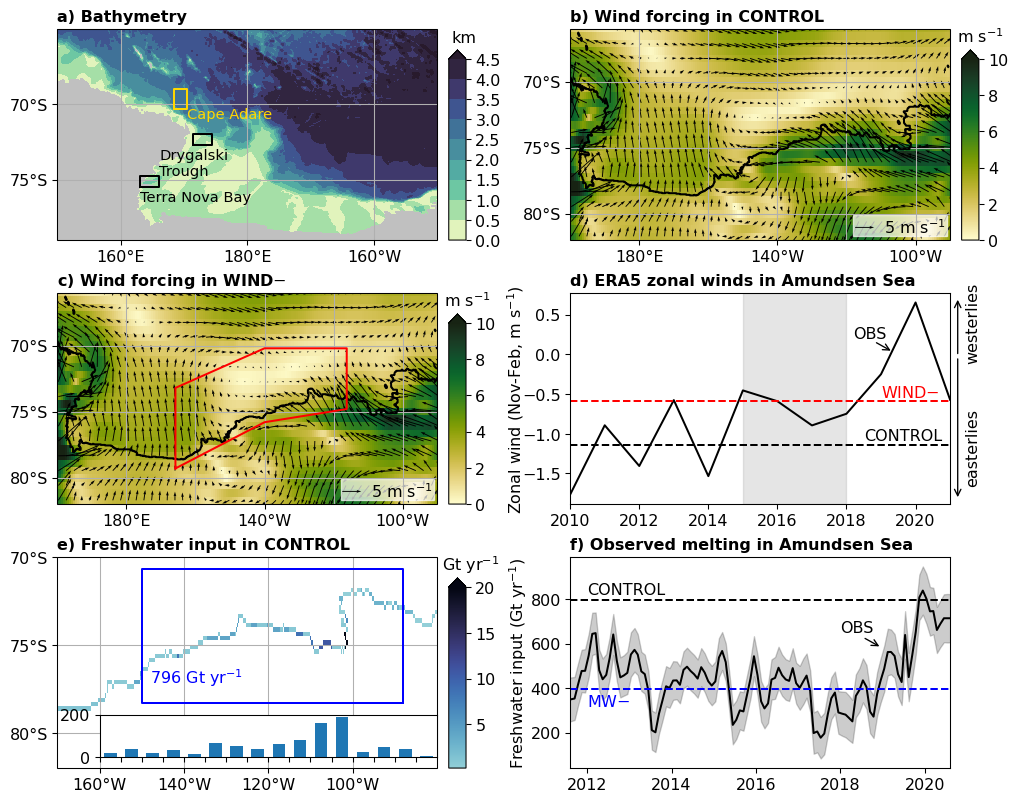

In [9]:
fig = plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=.25, wspace=.35)

proj = ccrs.PlateCarree()

""" a) Depth and region overview """
ax1 = fig.add_subplot(3, 2, 1, projection=ccrs.PlateCarree(central_longitude=185))
ax1.contourf(land_mask.xt_ocean, land_mask.yt_ocean,
            land_mask, colors='silver', levels=[0.5, 2],
            zorder=2, transform=proj)

ax1.set_extent([150, 210, -79, -65])
gl = ax1.gridlines(draw_labels=False)
gl.xlocator = mticker.FixedLocator(
    [160, 180, -160, -140])
ax1.set_xticks([160, 180, -160], crs=proj)
ax1.xaxis.set_major_formatter(LongitudeFormatter(
    dateline_direction_label=True))
gl.ylocator = mticker.FixedLocator(
    np.arange(-80, -65, 5))
ax1.set_yticks(np.arange(-80, -65, 5), crs=proj)
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set_ylim(-79, None)
ax1.set_aspect('auto')

p = ax1.contourf(ht.xt_ocean, ht.yt_ocean, ht/1000, cmap=cmo.deep,
                levels=np.arange(0, 5, .5), extend='max', transform=proj)
plt.plot([-197, -194, -194, -197, -197],
         [-75.5, -75.5, -74.75, -74.75, -75.5], 'k', transform=proj)
plt.text(-197, -75.7, 'Terra Nova Bay', va='top', fontsize=11, transform=proj)
plt.plot([-188.5, -185.5, -185.5, -188.5, -188.5],
         [-72.67, -72.67, -72, -72, -72.67], 'k', transform=proj)
plt.text(-193.9, -72.9, 'Drygalski\nTrough', va='top', fontsize=11, transform=proj)
plt.plot([-191.5, -189.5, -189.5, -191.5, -191.5], [-70.3, -70.3, -69, -69, -70.3],
         color='gold', transform=proj)
plt.text(-189.5, -70.2, 'Cape Adare', color='gold', va='top',
         fontsize=11, transform=proj)
plt.title('a) Bathymetry', fontweight='bold', loc='left')

pos = plt.gca().get_position()
cax = plt.axes([pos.xmax+.01, pos.ymin,
                0.015, .9*(pos.ymax-pos.ymin)])
cb = plt.colorbar(p, cax=cax, orientation='vertical', extend='max')
cb.ax.set_title('km', x=.9)


""" b + c) Wind forcing """ 
var_u = [exptdict['ctrl']['u'],  exptdict['wind_50_down_zonal']['u']]
var_v = [exptdict['ctrl']['v'],  exptdict['wind_50_down_zonal']['v']]
var_spd = [exptdict['ctrl']['spd'],  exptdict['wind_50_down_zonal']['spd']]
v_min = [0, 0]
v_max = [10, 10]
cmap = [cmo.speed, cmo.speed]
var_title = ['b) Wind forcing in ' + exptdict['ctrl']['expt_str'],
             'c) Wind forcing in ' + exptdict['wind_50_down_zonal']['expt_str']]

for p in range(len(var_u)):
    ax = fig.add_subplot(3, 2, p+2, projection=ccrs.PlateCarree(central_longitude=185))
    ax.set_extent([160, 270, -82, -66])
    gl = ax.gridlines(draw_labels=False)
    gl.xlocator = mticker.FixedLocator(
        [180, -160, -140, -120, -100])
    ax.set_xticks([180, -140, -100], crs=proj)
    ax.xaxis.set_major_formatter(LongitudeFormatter(
        dateline_direction_label=True))
    gl.ylocator = mticker.FixedLocator(
        np.arange(-80, -65, 5))
    ax.set_yticks(np.arange(-80, -65, 5), crs=proj)
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_ylim(-82, None)
    ax.set_aspect('auto')
    
    pc = plt.pcolormesh(var_spd[p].lon, var_spd[p].lat, var_spd[p],
                   vmin=v_min[p], vmax=v_max[p], cmap=cmap[p], transform=proj)
    plt.contour(land_mask.xt_ocean, land_mask.yt_ocean, land_mask,
                levels=[0, 1], colors = 'k', transform=proj)
    
    pp = 4
    if cmap[p] == cmo.balance:
        qk_max = 2
        qk_scale = 40
    else:
        qk_max = 5
        qk_scale = 100
    Q = plt.quiver(to_np(var_u[p].lon[::pp]), to_np(var_u[p].lat[::np.int(pp/2)]),
                   to_np(var_u[p][::np.int(pp/2), ::pp]),
                   to_np(var_v[p][::np.int(pp/2), ::pp]),
                   scale=qk_scale, transform=proj)
    box = plt.Rectangle(xy=(-118, -81.7), width=27, height=1.6, color='w',
                        alpha=.7, transform=proj)
    ax.add_patch(box)
    qk = plt.quiverkey(Q, .8, .06, qk_max, str(qk_max) + r' m s$^{-1}$',
                       labelpos='E')

    if p > 0:
        buffer = -1.2
        plt.plot([mask_wind[0][0]-buffer, mask_wind[0][1]-buffer, mask_wind[0][2],
                  mask_wind[0][3]+buffer, mask_wind[0][4]+buffer, mask_wind[0][5],
                  mask_wind[0][6]-buffer],
                 [mask_wind[1][0]-buffer, mask_wind[1][1]+buffer, mask_wind[1][2]+buffer,
                  mask_wind[1][3]+buffer, mask_wind[1][4]-buffer, mask_wind[1][5]-buffer,
                  mask_wind[1][6]-buffer],
                 color='r', transform=proj)
    plt.title(var_title[p], fontweight='bold', loc='left')

    pos = plt.gca().get_position()
    cax = plt.axes([pos.xmax+.01, pos.ymin,
                    0.015, .9*(pos.ymax-pos.ymin)])
    if cmap[p] == cmo.balance:
        cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='both')
    else:
        cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='max')
    cb.ax.set_title('m s$^{-1}$', x=1.1)

""" d) ERA5 winds """
buffer = -1.2
mask_wind_lon = (np.array([-167-buffer, -167-buffer, -140, -115+buffer,
                           -115+buffer, -140, -167-buffer]) + 360) % 360
mask_wind_lat = [-80-buffer, -72+buffer, -69+buffer , -69+buffer,
                 -76-buffer, -76-buffer, -80-buffer]
mask_wind_era = mask_from_polygon(
    mask_wind_lon, mask_wind_lat,
    exptdict['era5']['u'].lon, exptdict['era5']['u'].lat)
mask_wind_jra = mask_from_polygon(
    mask_wind_lon, mask_wind_lat,
    exptdict['ctrl']['u'].lon, exptdict['ctrl']['u'].lat)

fig.add_subplot(3, 2, 4)
(e['u'].where(mask_wind_era == 1).mean(['lon', 'lat']).sel(time=slice(2010, 2021))).plot(color='k')
plt.axvspan(2015, 2018, alpha=.2, color='grey')
u_ctrl = (exptdict['ctrl']['u'].where(mask_wind_jra == 1).mean(['lon', 'lat'])).values
plt.axhline(u_ctrl, color='k', linestyle='--')
plt.text(2018.5, u_ctrl+.05, exptdict['ctrl']['expt_str'])
u_wind_50_down = (exptdict['wind_50_down_zonal']['u'].where(mask_wind_jra == 1).mean(
    ['lon', 'lat'])).values
plt.axhline(u_wind_50_down, color='r', linestyle='--')
plt.text(2019, u_wind_50_down+.05, exptdict['wind_50_down_zonal']['expt_str'],
        color='r')
plt.text(2018.2, .2, 'OBS')
plt.annotate('', xy=(.85, .72), xycoords='axes fraction',
                     xytext=(.8, .77),
                     arrowprops=dict(arrowstyle="->", color='k'))
plt.autoscale(enable=True, axis='x', tight=True)
plt.annotate('', xy=(1.02, .7), xycoords='axes fraction',
                     xytext=(1.02, .98),
                     arrowprops=dict(arrowstyle="<-", color='k'))
plt.text(1.04, .68, 'westerlies', rotation=90, transform=plt.gca().transAxes)
plt.annotate('', xy=(1.02, .02), xycoords='axes fraction',
                     xytext=(1.02, .7),
                     arrowprops=dict(arrowstyle="->", color='k'))
plt.text(1.04, .1, 'easterlies', rotation=90, transform=plt.gca().transAxes)

plt.xlabel('')
plt.ylabel('Zonal wind (Nov-Feb, m s$^{-1}$)', labelpad=-3)
plt.title('d) ERA5 zonal winds in Amundsen Sea', fontweight='bold', loc='left')


""" e) Freshwater input from JRA """
ax5 = fig.add_subplot(3, 2, 5, projection=ccrs.PlateCarree(central_longitude=185))

ax5.set_extent([190, 280, -82, -70])
gl = ax5.gridlines(draw_labels=False)
gl.xlocator = mticker.FixedLocator(
    np.arange(-160, -80, 20))
ax5.set_xticks([-160, -140, -120, -100], crs=proj)
ax5.xaxis.set_major_formatter(LongitudeFormatter(
    dateline_direction_label=True))
gl.ylocator = mticker.FixedLocator(
    np.arange(-80, -70, 5))
ax5.set_yticks([-80, -75, -70], crs=proj)
ax5.yaxis.set_major_formatter(LatitudeFormatter())
plt.ylim(-82, None)
ax5.set_aspect('auto')

p = plt.pcolormesh(
    runoff_Gt.longitude, runoff_Gt.latitude, runoff_Gt,
    vmax=20, cmap=cmocean.tools.crop(cmapin=cmo.ice_r, vmin=.1, vmax=1, pivot=.45),
    transform=proj)

plt.plot([-88, -88, -150, -150, -88], [-78.3, -70.7, -70.7, -78.3, -78.3],
         color='b', transform=proj)
plt.text(-148, -77.2, str(np.int(runoff_Gt.where(
    (runoff.latitude <= -70) &
    (runoff.longitude >= 360-150) & (runoff.longitude <= 360-88)).sum().values)) +
         ' Gt yr$^{-1}$', transform=proj, color='b')

ax5.set_title('e) Freshwater input in CONTROL', fontweight='bold', loc='left')

pos = ax5.get_position()
cax = plt.axes([pos.xmax+.01, pos.ymin,
                0.015, .9*(pos.ymax-pos.ymin)])
cb = plt.colorbar(p, cax=cax, orientation='vertical', extend='max')
cb.ax.set_title('Gt yr$^{-1}$', x=1.3)


ax5ins = inset_axes(ax5, width="88.7%", height="20%", bbox_to_anchor=(.02, .015, 1, 1),
                    bbox_transform=ax5.transAxes, loc='lower right')
runoff_Gt_binned = []
for i, l in enumerate(np.arange(200, 280, 5)):
    runoff_Gt_binned.append(runoff_Gt.where(
        (runoff_Gt.longitude >= l) & (runoff_Gt.longitude < l+5), drop=True).sum().values)
ax5ins.bar(np.arange(202.5-360, 280-360, 5), runoff_Gt_binned, width=3)
ax5ins.set_xticks(np.arange(200-360, 280-360, 5))
ax5ins.set_xticklabels([])
ax5ins.set_xlim(-160, -80)


""" f) Timeseries from Davison 2023 """
ax6 = fig.add_subplot(3, 2, 6)
e_glaciers = exptdict_glaciers['all']
plt.plot(exptdict_glaciers['Getz']['df'].dates_decimal, e_glaciers['melt'], 'k')
plt.fill_between(exptdict_glaciers['Getz']['df'].dates_decimal,
                 e_glaciers['melt'] - e_glaciers['melt_err'], 
                 e_glaciers['melt'] + e_glaciers['melt_err'], color='k', alpha=.2)
plt.axhline(796, color='k', linestyle='--')
plt.text(2012, 820, exptdict['ctrl']['expt_str'])
plt.axhline(398, color='b', linestyle='--')
plt.text(2012, 320, exptdict['mw_50_down']['expt_str'], color='b')
plt.text(2018, 650, 'OBS')
plt.annotate('', xy=(.82, .57), xycoords='axes fraction',
                     xytext=(.77, .62),
                     arrowprops=dict(arrowstyle="->", color='k'))
plt.xlim(2011.6, 2020.6)

plt.ylabel('Freshwater input (Gt yr$^{-1}$)', labelpad=1)
plt.title('f) Observed melting in Amundsen Sea', fontweight='bold', loc='left')

plt.savefig(path_plots + 'Fig1.png', dpi=300, bbox_inches="tight")
plt.show()